# Importing Necessary Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\AORUS\AppData\Local\Temp\ipykernel_15596\1491445465.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# (1) Loading The Dataset

In [2]:
def load_dataset(dataset_path, img_size):
    images = []
    labels = []

    for label_folder in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_folder)

        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            img = cv2.imread(image_path)

            img = cv2.resize(img, img_size)

            images.append(img)
            labels.append(label_folder)

    return np.array(images), np.array(labels)

# (2) Label Encoding

In [3]:
def label_encoding(data_labels):
    # ('glioma': 0 / 'meningioma': 1 / 'notumor': 2 / 'pituitary': 3)
    general_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

    new_data_labels = []
    for label in data_labels:
        new_data_labels.append(general_labels.index(label))

    return np.array(new_data_labels)

# (3) Data Augmentation

In [4]:
def plot_augmented_samples(X_train, train_datagen, seed=None):

    def plot_images(images, titles, ncols=6, figsize=(15, 15)):
        fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
        for i, (img, title) in enumerate(zip(images, titles)):
            ax[i].imshow(img)
            ax[i].set_title(title)
            ax[i].axis('off')
        plt.show()

    if seed != None:
        np.random.seed(seed)

    sample_indices = np.random.choice(len(X_train), 3, replace=False)
    samples = X_train[sample_indices]

    for sample in samples:
        images = [sample]  # Start with the original image
        titles = ['Original']

        generator = train_datagen.flow(sample.reshape((1,) + sample.shape), batch_size=1)

        # Generate 5 augmented images
        for i in range(5):
            augmented_image = next(generator)[0]
            if augmented_image.dtype in ['float32', 'float64']:
                augmented_image = (augmented_image * 255).astype('uint8')
            images.append(augmented_image)
            titles.append(f'Augmented {i+1}')

        plot_images(images, titles)


In [5]:
def make_generators(X_train, X_val, X_test, encoded_y_train, encoded_y_val, encoded_y_test, batch_size, augment=False):
    if augment:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest')
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    # For validation and test data, you typically only rescale
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    if augment:
        plot_augmented_samples(X_train, train_datagen)
    
    train_generator = train_datagen.flow(X_train, encoded_y_train, batch_size=batch_size, shuffle=True, seed=101)

    val_generator = val_datagen.flow(X_val, encoded_y_val, batch_size=batch_size, shuffle=False)

    test_generator = test_datagen.flow(X_test, encoded_y_test, batch_size=batch_size, shuffle=False)

    return train_generator, val_generator, test_generator

# (4) Model Architectures

In [6]:
def create_basic_cnn(input_shape, filters, kernel_size, pool_size, dropout_rate, n_hidden):
    model = Sequential()
    model.add(Conv2D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size))

    for f in filters[1:]:
        model.add(Conv2D(filters=f, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten())

    for n in n_hidden:
        model.add(Dense(units=n, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=4, activation='softmax'))
    
    print(model.summary())
    return model

In [7]:
def create_vgg16(input_shape, dropout_rate):
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg16_base.trainable = False

    model = Sequential()
    
    model.add(vgg16_base)
    model.add(Flatten())
    
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    
    print(model.summary())
    return model

In [8]:
def create_resnet50(input_shape, dropout_rate):
    resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet50_base.trainable = False
    
    model = Sequential()
    
    model.add(resnet50_base)
    model.add(Flatten())

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    
    print(model.summary())
    return model

In [9]:
def get_model(model_type, params):
    if model_type == 'basic_cnn':
        return create_basic_cnn(
            input_shape=params['input_shape'],
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            pool_size=params['pool_size'],
            dropout_rate=params['dropout_rate'],
            n_hidden=params['n_hidden']
        )
    elif model_type == 'vgg16':
        return create_vgg16(input_shape=params['input_shape'], dropout_rate=params['dropout_rate'])
    elif model_type == 'resnet50':
        return create_resnet50(input_shape=params['input_shape'], dropout_rate=params['dropout_rate'])
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# (5) Model Evaluation

In [10]:
def plot_results(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_confusion_matrix(model, test_generator, encoded_y_test):
    predictions = model.predict(test_generator)
    predicted_classes = [np.argmax(pred) for pred in predictions]

    conf_matrix = confusion_matrix(encoded_y_test, predicted_classes)

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(i, j, str(conf_matrix[i, j]), ha='center', va='center')

    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

In [12]:
def plot_classification_report(model, test_generator, encoded_y_test):
    predictions = model.predict(test_generator)
    predicted_classes = [np.argmax(pred) for pred in predictions]
    
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    report = classification_report(encoded_y_test, predicted_classes, target_names=classes, output_dict=True)
    
    metrics = {label: report[label] for label in classes if label in report}
    
    precision = [metrics[label]['precision'] for label in classes]
    recall = [metrics[label]['recall'] for label in classes]
    f1_score = [metrics[label]['f1-score'] for label in classes]
    
    data = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }
    
    df = pd.DataFrame(data, index=classes)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

In [13]:
def evaluate_model(model, test_generator):
    evaluation = model.evaluate(test_generator)
    test_loss = evaluation[0]
    test_accuracy = evaluation[1]
    
    return test_loss, test_accuracy

# (6) Experiment Execution

In [14]:
def run_experiment(params, X_train, X_val, X_test, encoded_y_train, encoded_y_val, encoded_y_test):
    model = get_model(params['model_type'], params)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    train_gen, val_gen, test_gen = make_generators(
        X_train, X_val, X_test,
        encoded_y_train, encoded_y_val, encoded_y_test,
        batch_size=params['batch_size'],
        augment=params['augment']
    )

    history = model.fit(train_gen, validation_data=val_gen, epochs=params['epochs'], verbose=1)
    plot_results(history)

    plot_confusion_matrix(model, test_gen, encoded_y_test)

    plot_classification_report(model, test_gen, encoded_y_test)

    loss, accuracy = evaluate_model(model=model, test_generator=test_gen)

    result = {
        'Model': model,
        'Model Type': params['model_type'],
        'With Augmentation': 'Yes' if params['augment'] else 'No',
        'Test Loss': loss,
        'Test Accuracy': accuracy
    }
    
    return result

# (7) Best Model Save

In [15]:
def save_best_model(results, save_path='../saved_models/best_classification_model.h5'):
    best_model = None
    best_accuracy = 0

    for result in results:
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model = result['model']

    if best_model:
        save_model(best_model, save_path)
        print(f"Best model saved to {save_path}")
    else:
        print("No best model found to save.")

# Main Execution

In [16]:
experiments = [
    {
        'model_type': 'basic_cnn',
        'dropout_rate': 0.5,
        'filters': [32, 64, 128, 256],
        'input_shape': (150, 150, 3),
        'epochs': 20,
        'batch_size': 32,
        'kernel_size': (3, 3),
        'pool_size': (2, 2),
        'n_hidden': [512],
        'augment': True,
        'image_size': (150, 150)
    },
    {
        'model_type': 'vgg16',
        'dropout_rate': 0.5,
        'input_shape': (224, 224, 3),
        'epochs': 20,
        'batch_size': 32,
        'augment': True,
        'image_size': (224, 224)
    },
    {
        'model_type': 'resnet50',
        'dropout_rate': 0.5,
        'input_shape': (224, 224, 3),
        'epochs': 20,
        'batch_size': 32,
        'augment': True,
        'image_size': (224, 224)
    }
]

In [17]:
brain_dataset_training_path = '../BT_Dataset/Training'
brain_dataset_testing_path = '../BT_Dataset/Testing'

Running experiment with parameters: {'model_type': 'basic_cnn', 'dropout_rate': 0.5, 'filters': [32, 64, 128, 256], 'input_shape': (150, 150, 3), 'epochs': 20, 'batch_size': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'n_hidden': [512], 'augment': True, 'image_size': (150, 150)}
Train images shape is : (4569, 150, 150, 3)
Train labels shape is : (4569,)
Validation images shape is : (1143, 150, 150, 3)
Validation labels shape is : (1143,)
Test images shape is : (1311, 150, 150, 3)
Test labels shape is : (1311,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                              

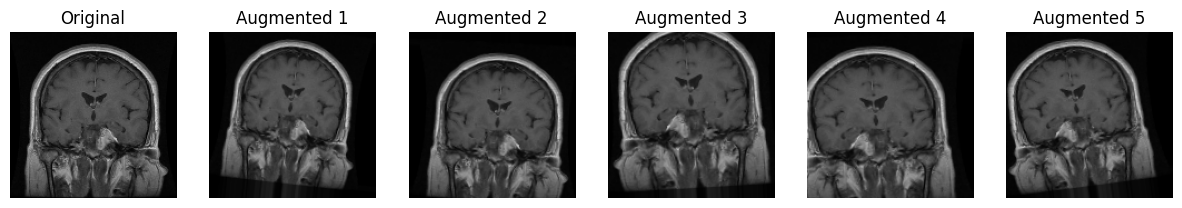

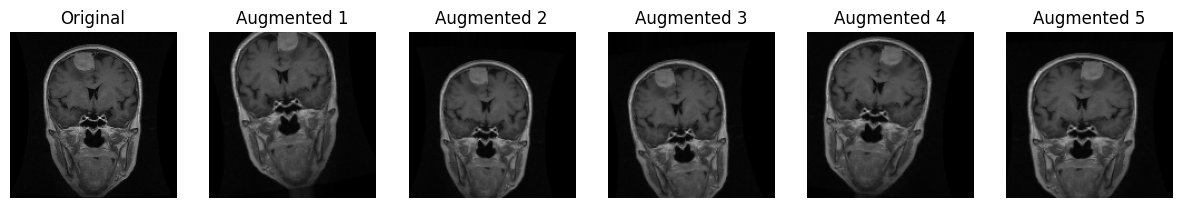

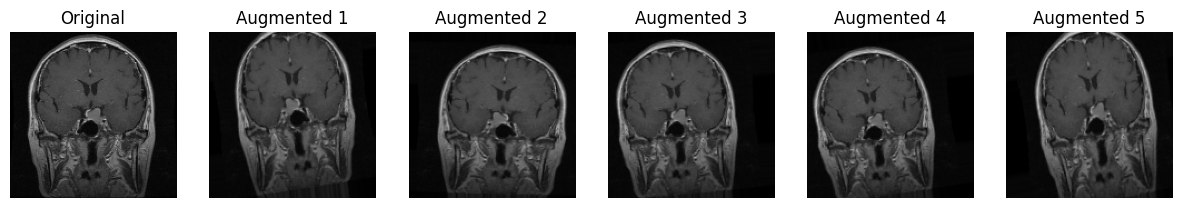

Epoch 1/20


143/143 [==============================] - 46s 314ms/step - loss: 0.9408 - accuracy: 0.5929 - val_loss: 0.8753 - val_accuracy: 0.6483
Epoch 2/20
143/143 [==============================] - 45s 312ms/step - loss: 0.5884 - accuracy: 0.7700 - val_loss: 0.5562 - val_accuracy: 0.8005
Epoch 3/20
143/143 [==============================] - 45s 316ms/step - loss: 0.5149 - accuracy: 0.7938 - val_loss: 0.4046 - val_accuracy: 0.8399
Epoch 4/20
143/143 [==============================] - 45s 313ms/step - loss: 0.4453 - accuracy: 0.8225 - val_loss: 0.4198 - val_accuracy: 0.8408
Epoch 5/20
143/143 [==============================] - 45s 316ms/step - loss: 0.3695 - accuracy: 0.8569 - val_loss: 0.3904 - val_accuracy: 0.8539
Epoch 6/20
143/143 [==============================] - 44s 308ms/step - loss: 0.3281 - accuracy: 0.8772 - val_loss: 0.4956 - val_accuracy: 0.8233
Epoch 7/20
143/143 [==============================] - 45s 317ms/step - loss: 0.3110 - accuracy: 0.8836 - val_loss: 0.4007 - val_

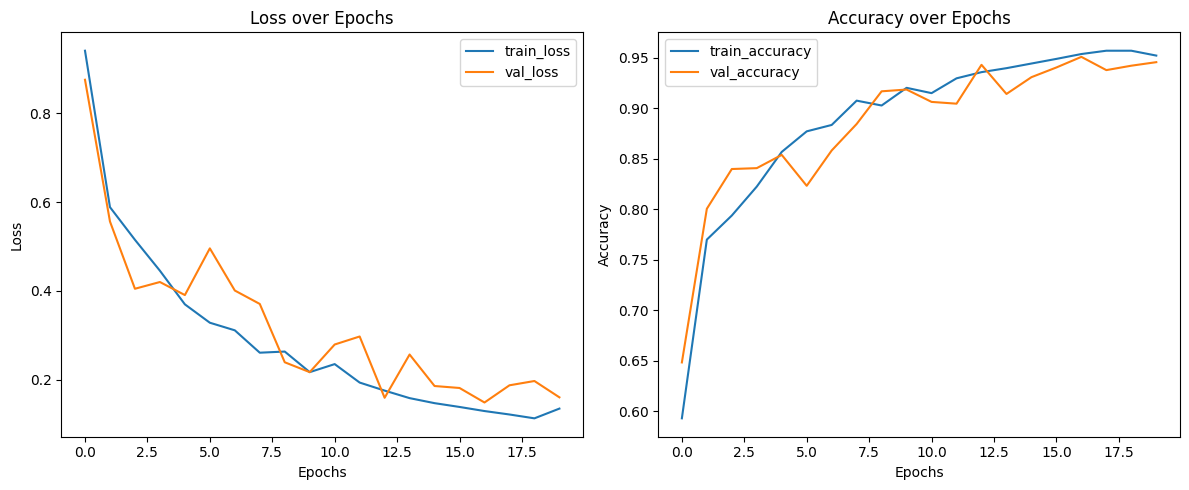

41/41 [==============================] - 3s 60ms/step


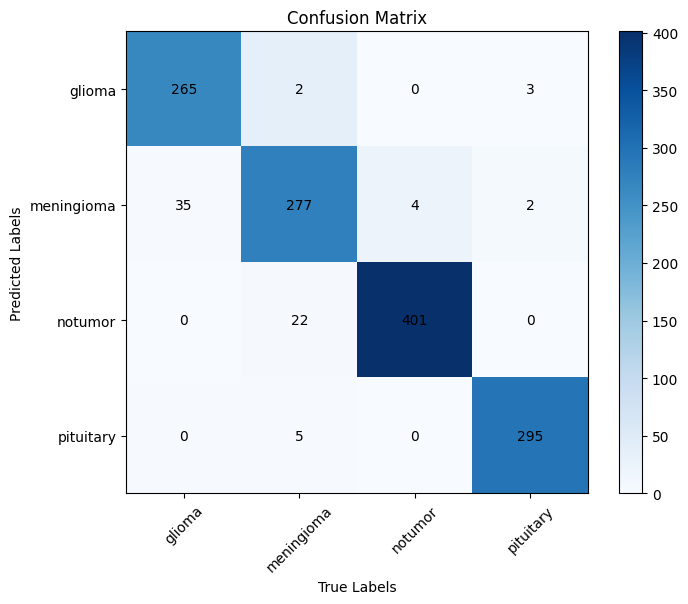

41/41 [==============================] - 2s 58ms/step


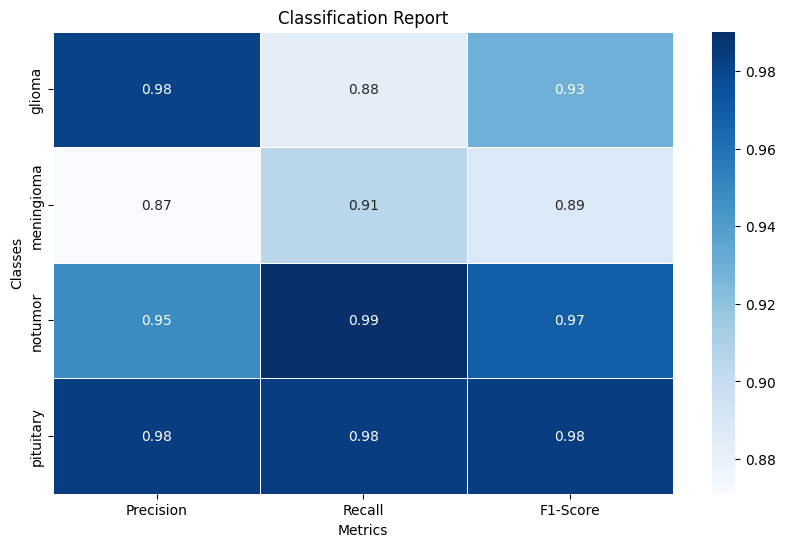

41/41 [==============================] - 2s 57ms/step - loss: 0.1500 - accuracy: 0.9443
Running experiment with parameters: {'model_type': 'vgg16', 'dropout_rate': 0.5, 'input_shape': (224, 224, 3), 'epochs': 20, 'batch_size': 32, 'augment': True, 'image_size': (224, 224)}


C:\Users\AORUS\AppData\Local\Temp\ipykernel_15596\2942225062.py:25: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(result['Model'], f"../saved_models/model_type_variant/augmented/{params['model_type']}_augmented", save_format='h5')


Train images shape is : (4569, 224, 224, 3)
Train labels shape is : (4569,)
Validation images shape is : (1143, 224, 224, 3)
Validation labels shape is : (1143,)
Test images shape is : (1311, 224, 224, 3)
Test labels shape is : (1311,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              16781312  
                

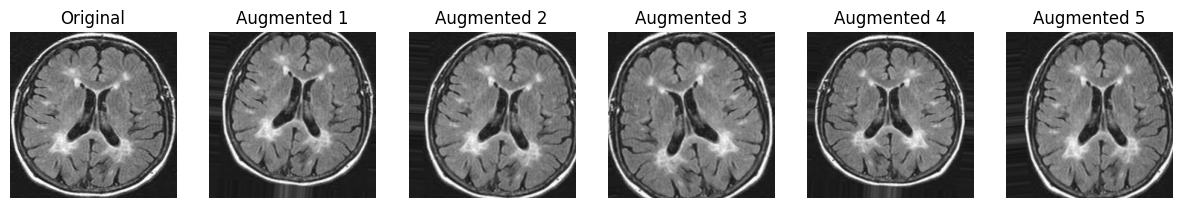

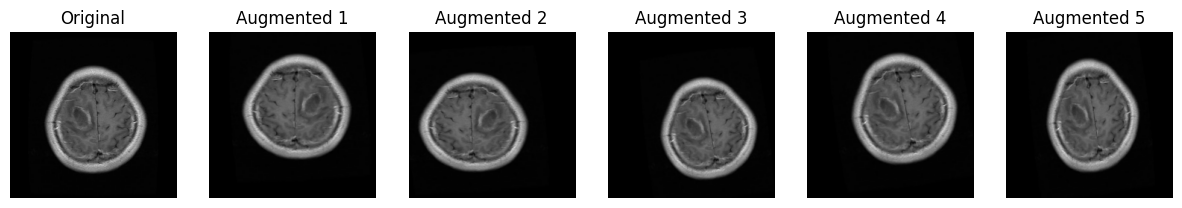

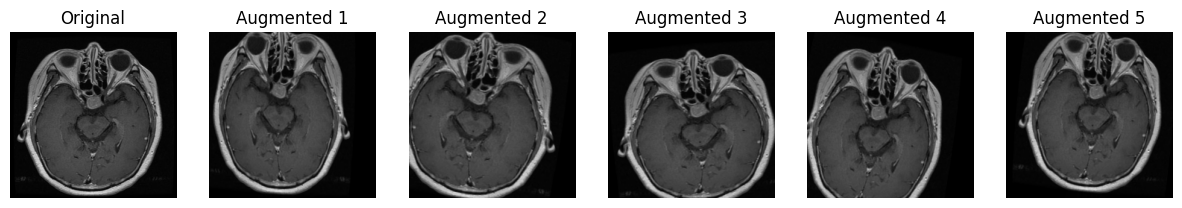

Epoch 1/20
143/143 [==============================] - 387s 3s/step - loss: 2.1907 - accuracy: 0.6807 - val_loss: 0.4484 - val_accuracy: 0.8276
Epoch 2/20
143/143 [==============================] - 389s 3s/step - loss: 0.6306 - accuracy: 0.7582 - val_loss: 0.3515 - val_accuracy: 0.8670
Epoch 3/20
143/143 [==============================] - 365s 3s/step - loss: 0.6135 - accuracy: 0.7603 - val_loss: 0.4343 - val_accuracy: 0.8180
Epoch 4/20
143/143 [==============================] - 363s 3s/step - loss: 0.5999 - accuracy: 0.7669 - val_loss: 0.4247 - val_accuracy: 0.8399
Epoch 5/20
143/143 [==============================] - 361s 3s/step - loss: 0.5965 - accuracy: 0.7608 - val_loss: 0.3945 - val_accuracy: 0.8696
Epoch 6/20
143/143 [==============================] - 362s 3s/step - loss: 0.5534 - accuracy: 0.7833 - val_loss: 0.3670 - val_accuracy: 0.8749
Epoch 7/20
143/143 [==============================] - 363s 3s/step - loss: 0.6028 - accuracy: 0.7647 - val_loss: 0.3557 - val_accuracy: 0.8793

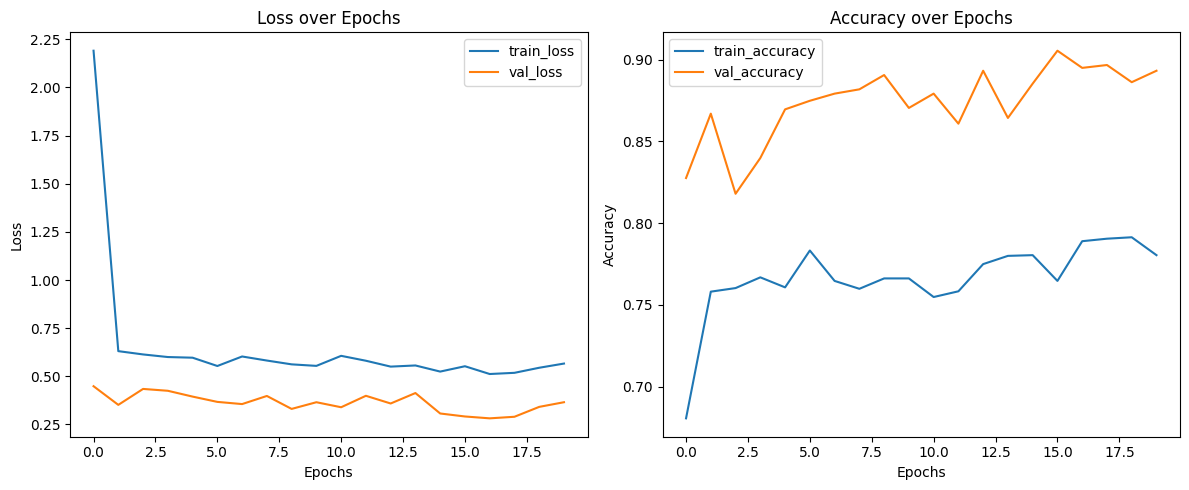

41/41 [==============================] - 56s 1s/step


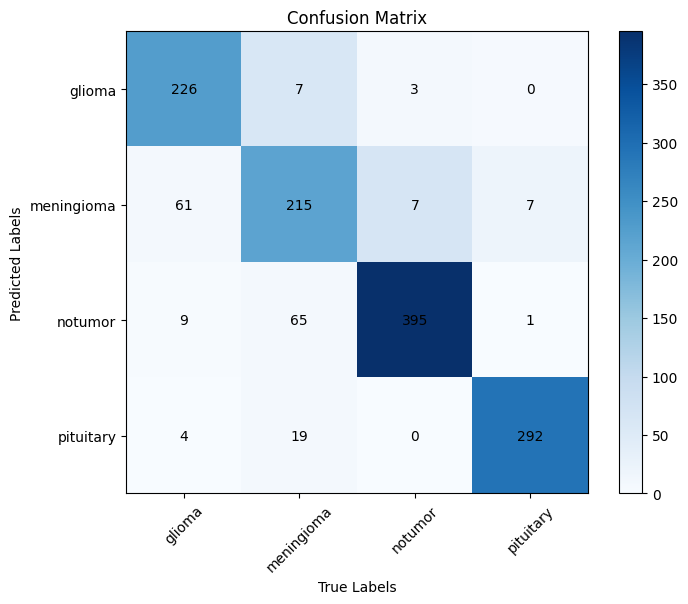

41/41 [==============================] - 56s 1s/step


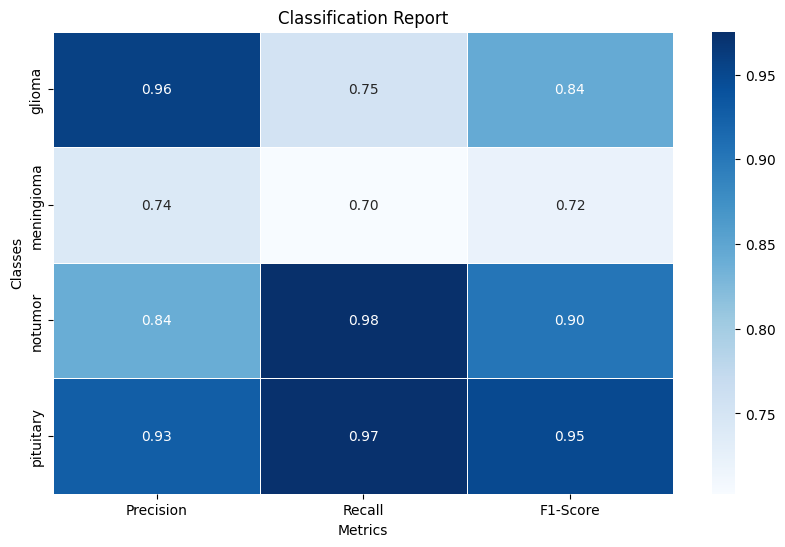

41/41 [==============================] - 57s 1s/step - loss: 0.4372 - accuracy: 0.8604


C:\Users\AORUS\AppData\Local\Temp\ipykernel_15596\2942225062.py:25: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(result['Model'], f"../saved_models/model_type_variant/augmented/{params['model_type']}_augmented", save_format='h5')


Running experiment with parameters: {'model_type': 'resnet50', 'dropout_rate': 0.5, 'input_shape': (224, 224, 3), 'epochs': 20, 'batch_size': 32, 'augment': True, 'image_size': (224, 224)}
Train images shape is : (4569, 224, 224, 3)
Train labels shape is : (4569,)
Validation images shape is : (1143, 224, 224, 3)
Validation labels shape is : (1143,)
Test images shape is : (1311, 224, 224, 3)
Test labels shape is : (1311,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 4096)              411045888 
                                                                 
 dropout_3 (Dropout)     

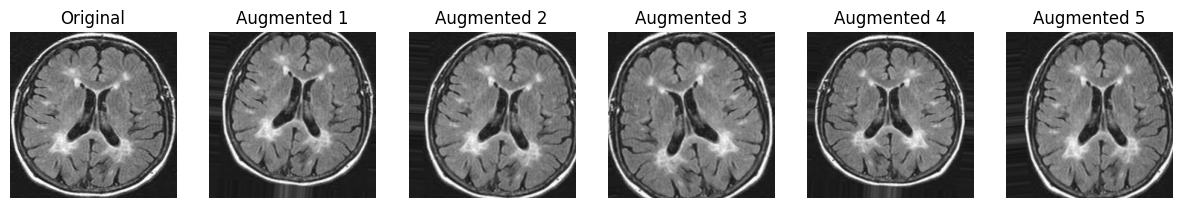

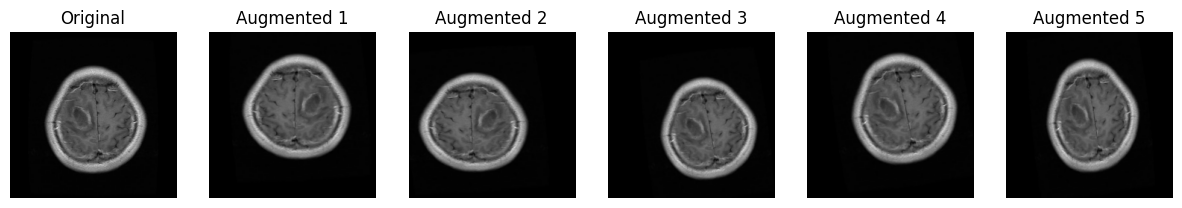

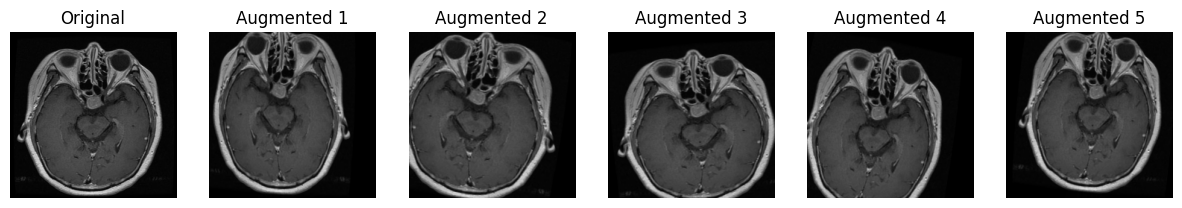

Epoch 1/20
143/143 [==============================] - 664s 5s/step - loss: 6.1960 - accuracy: 0.3539 - val_loss: 1.1729 - val_accuracy: 0.4506
Epoch 2/20
143/143 [==============================] - 636s 4s/step - loss: 1.2409 - accuracy: 0.3852 - val_loss: 1.1607 - val_accuracy: 0.4593
Epoch 3/20
143/143 [==============================] - 644s 5s/step - loss: 1.2328 - accuracy: 0.3872 - val_loss: 1.1127 - val_accuracy: 0.4637
Epoch 4/20
143/143 [==============================] - 636s 4s/step - loss: 1.2306 - accuracy: 0.3916 - val_loss: 1.1722 - val_accuracy: 0.3955
Epoch 5/20
143/143 [==============================] - 636s 4s/step - loss: 1.2433 - accuracy: 0.3826 - val_loss: 1.1159 - val_accuracy: 0.4663
Epoch 6/20
143/143 [==============================] - 638s 4s/step - loss: 1.2573 - accuracy: 0.3749 - val_loss: 1.1213 - val_accuracy: 0.4786
Epoch 7/20
143/143 [==============================] - 635s 4s/step - loss: 1.2500 - accuracy: 0.3793 - val_loss: 1.1013 - val_accuracy: 0.4742

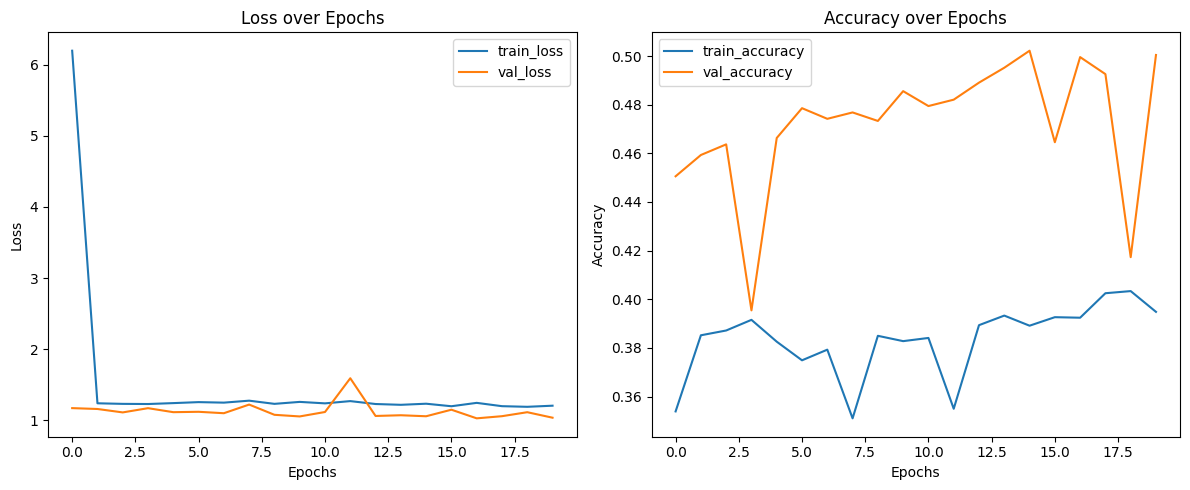

41/41 [==============================] - 49s 1s/step


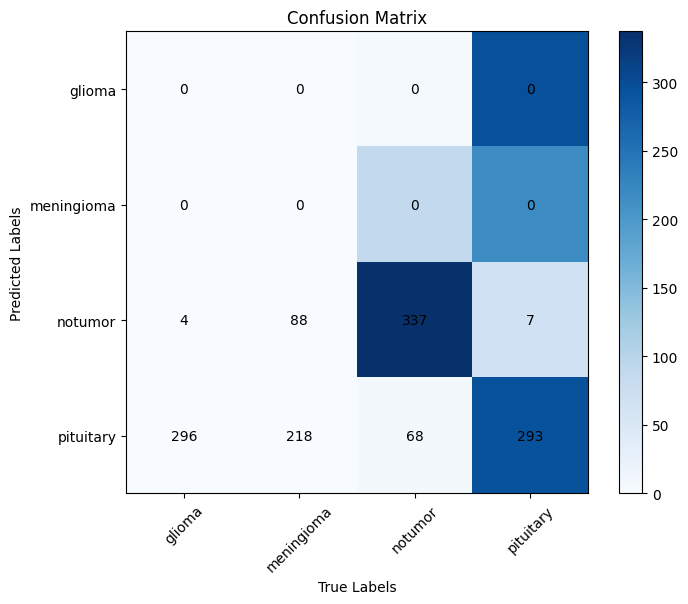

41/41 [==============================] - 48s 1s/step


c:\Users\AORUS\Desktop\MyProjects\VisBrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AORUS\Desktop\MyProjects\VisBrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AORUS\Desktop\MyProjects\VisBrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

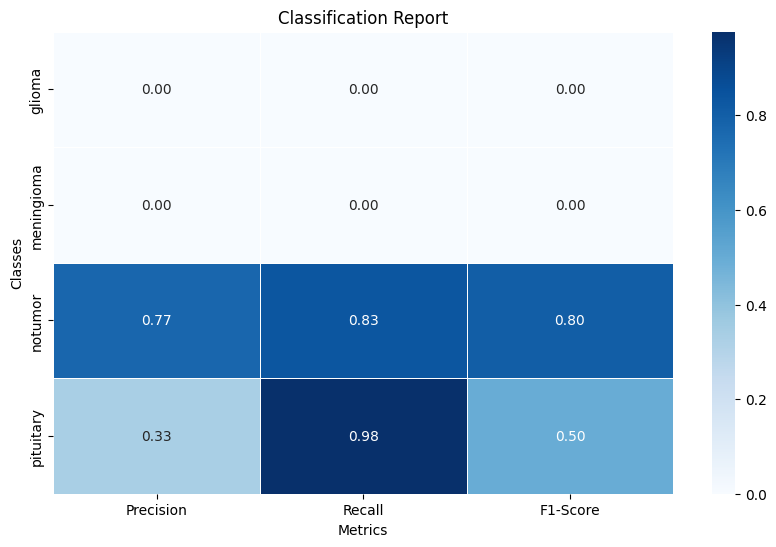

41/41 [==============================] - 48s 1s/step - loss: 1.0816 - accuracy: 0.4805


C:\Users\AORUS\AppData\Local\Temp\ipykernel_15596\2942225062.py:25: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(result['Model'], f"../saved_models/model_type_variant/augmented/{params['model_type']}_augmented", save_format='h5')


MemoryError: Unable to allocate 1.53 GiB for an array with shape (100352, 4096) and data type float32

In [18]:
results_with_augmentation = []

for params in experiments:
    print(f"Running experiment with parameters: {params}")
    
    X_train, y_train = load_dataset(brain_dataset_training_path, params['image_size'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    X_test, y_test = load_dataset(brain_dataset_testing_path, params['image_size'])

    encoded_y_train = label_encoding(y_train)
    encoded_y_val = label_encoding(y_val)
    encoded_y_test = label_encoding(y_test)

    print(f'Train images shape is : {X_train.shape}')
    print(f'Train labels shape is : {encoded_y_train.shape}')

    print(f'Validation images shape is : {X_val.shape}')
    print(f'Validation labels shape is : {encoded_y_val.shape}')

    print(f'Test images shape is : {X_test.shape}')
    print(f'Test labels shape is : {encoded_y_test.shape}')
    
    result = run_experiment(params, X_train, X_val, X_test, encoded_y_train, encoded_y_val, encoded_y_test)
    
    save_model(result['Model'], f"../saved_models/model_type_variant/augmented/{params['model_type']}_augmented", save_format='h5')

    results_with_augmentation.append(result)


In [19]:
results_W_A = pd.DataFrame(results_with_augmentation)
results_W_A.to_csv('../saved_models/model_type_variant/augmented/results_with_augmentation.csv', index=False)
results_W_A

,Model,Model Type,With Augmentation,Test Loss,Test Accuracy
0,<keras.src.engine.sequential.Sequential object...,basic_cnn,Yes,0.149997,0.944317
1,<keras.src.engine.sequential.Sequential object...,vgg16,Yes,0.437246,0.860412
2,<keras.src.engine.sequential.Sequential object...,resnet50,Yes,1.081565,0.480549
